# Modelowanie językowe na poziomie znakowym przy użyciu sieci rekurencyjnych.

Zadanie polega na utworzeniu sieci rekurencyjnej LSTM (opcjonalnie GRU), która będzie przewidywała kolejne znaki na podstawie wczytanej sekwencji. W rezultacie sieć będizew stanie wygenerować nowy tekst w tym samym stylu co wejściowy.

Pomocne tutoriale: 

https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html


https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html


Import danych tekstowych.

In [ ]:
import random
import re
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable



with open('./mickiewicz.txt', 'r') as f:
    file=f.read()

file_len = len(file)
print('file_len =', file_len)

#Poniżej pozbywamy się elementów zbędnych w naszej analizie
file = file.replace("\n", "")
file = file.replace("\t", "")
file = file.replace("\u2009", "")

all_characters = list(set(file)) #lista znaków, które występują w tekscie
n_characters = len(all_characters) #liczba zanków
print(all_characters)
print(n_characters)


file_len = 75575
['O', 'a', 'g', ',', 'G', 'S', 'ś', ' ', 'ż', '?', 'l', '2', 'd', '[', 'U', 'P', 'ą', 'I', 'H', 'ń', ']', 'é', 'M', 'F', '3', 'o', 'z', 'ł', 'j', 'J', 's', 'ź', '„', 'e', 'B', '4', 'E', 'c', ':', '—', 'w', 'Ż', 'y', 'b', 'N', 'm', '5', 't', '.', 'ę', '“', '1', 'Ł', '6', 'f', 'n', 'W', 'h', ')', '-', '7', 'r', 'D', 'C', 'T', '(', 'K', ';', 'A', 'Ś', 'R', 'x', 'L', 'k', 'i', 'ó', 'Z', '!', 'p', 'ć', '"', 'u']
82


 Funkcja zwracająca losowy fragment tekstu o zadanej długości chunk_len.

---



In [ ]:
chunk_len = 200

def random_chunk():
    #Your code
    start_index = random.randint(0, len(file)-chunk_len)  #wylosuj indeks wyznaczający początek tekstu
    end_index = start_index + chunk_len
    return file[start_index:end_index]

rand = random_chunk()

print(rand)
print(len(rand))

w i westchnień, i nowych powitań.Gdy się pan Wojski dosyć napytał, nabadał,Na samym końcu dzieje tego dnia powiadał. "Dobrze, mój Tadeuszu (bo tak nazywanoMłodzieńca, który nosił Kościuszkowskie miano
200


Funkcja zwracająca tensor z indeksami znaków w ciągu

In [ ]:
def char_to_tensor(string, all_characters):
    tensor = torch.zeros(len(string)).long()
    for i, char in enumerate(string):
      tensor[i] = all_characters.index(char)
    return tensor

print(char_to_tensor('abcDEFABCąąąaZ', all_characters)) #test funkcji (usunąłem elementy: 0 oraz Q ponieważ nie występują one pośród naszych znaków, a to na nich będziemy operować)

tensor([ 1, 43, 37, 62, 36, 23, 68, 34, 63, 16, 16, 16,  1, 76])


In [ ]:
all_characters[-2]

'"'

Funkcja, przekształca indeksy na "one-hot vectors". Jedynka w wektorze reprezentuje indkes znaku np:

index=2,
liczba znakow =5

one_hot_vector=[0,0,1,0,0]

lub

index=0,
liczba znakow =5

one_hot_vector=[1,0,0,0,0]

---



In [ ]:
def one_hot_encoder(arr, n_labels):
    one_hot_vector = torch.zeros(arr.shape[0], n_labels)
    for row_idx, char_idx in enumerate(arr):
      one_hot_vector[row_idx, char_idx] = 1

    return one_hot_vector

print(one_hot_encoder(char_to_tensor('GabcDEFABCąąąaZ?x?', all_characters), n_characters))
print(one_hot_encoder(char_to_tensor('GabcDEFABCąąąaZ?x?', all_characters), n_characters).shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([18, 82])


### Model sieci

- __init__ przypisanie parametrów sieci oraz utworzenie warstw: LSTM, linear, ew. dropout

      a)lstm - 3 parametry: rozmiar wejścia, rozmiar "ukryty" oraz liczba warstw

      b) Linear -warstwa pobierajca wejście z lstm i zwracająca wyjście całej sieci

- forward - kolejne operacje na warstwach:lstm i linear. 
werstwa lstm  otrzymuje na wejściu wektor zerojedynkowy oraz poprzedni stan ukryty  oraz stan komórki$(h_{t-1}, c_{t-1})$, to na początku wektor zerowy). Wektor wejsciowy powinien być 3d: (seq_len, batch, input_size) - dlugosc wczytywanej sekwencji na raz (tutaj mamy pojedyncza litere), rozmiar batcha, rozmiar wektora wejściowego.

  Lstm zwraca wyjście (ostatnią wartość w danym kroku t dla wszystkich wartstw jesli jest wiecej) oraz $(h_{t}, c_{t})$ stan ukryty i stan komórki (wartości z każdego kroku  dla ostatniej warstwy ) w kroku t równemu długości sekwencji, 
  
  Wyjscie LSTM  przekazywane jest do warstwy liniowej i jest zwracane przez metodę razem z warstwą ukrytą

- init_hidden, zwraca ( h_t, c_t) w początkowym stanie (wszystkie wymiary ustawione na zero)  h_t jest ukrytym stanem czyli wyjściem (hidden state lub output) w czasie t, c_t jest stanem komórki (cell state ) w kroku t, 



https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#torch.nn.LSTM

In [185]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        #Your code
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.lin  = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, inp, hidden):
        output, hidden = self.lstm(inp.to(device), hidden) #your code - wejście do warstwy lstm 
        output = self.lin(output)
         #Your code - przekazanei wyjscia warstwy lstm do warstwy linear
        return output, hidden

    def init_hidden(self):
        return (torch.zeros(self.n_layers, 1, self.hidden_size),
                torch.zeros(self.n_layers, 1, self.hidden_size))

### funkcja zwraca zbiór treningowy powstały z losowego fragmentu tekstu. "inp" to wszystkie kolejne znaki fragmentu bez ostatniego, a "target" wszystkie znaki bez pierwszego. Wejście jest przekształconena wektory zerojedynkowe a wyjście jedynie na indeksy (postać wyjścia zależy od wyboru implementacji funkcji kosztu w pytorch)

In [139]:
def random_training_set():    
    chunk = random_chunk()
    tensor_chunk = char_to_tensor(chunk, all_characters)
    inp = one_hot_encoder(tensor_chunk[0:len(tensor_chunk)-1], n_characters)
    target = one_hot_encoder(tensor_chunk[1:], n_characters)
    return inp, target

#### Funkcja zwracająca próbkę wygenerowanego tekstu - wykorzystywana do sprawdzenia jak działa sieć w trakcie trenowania

*   List item
*   List item



In [199]:
def sample(start_str='A', predict_len=100):
    #uruchomienie sieci i zamiana ciągu znaków na tensor
    hidden = rnn.init_hidden()
    start_input = char_to_tensor(start_str, all_characters) #zamień tekst wejsciowy na indeksy
    start_input = one_hot_encoder(start_input, n_characters) # zamień start_input na "one-hot vector"
    predicted = start_str

    #uruchomienie sieci dla początkowych liter tak aby "pamiętała" całe wejściem. nie potrzebujemy jeszcze zapisywać wyjścia tylko stan ukryty
    for p in range(len(start_str) - 1):
        _, hidden = rnn.forward(start_input.view(1, 1, 82), hidden) #your code 
        
    #ostatnia litera - będzie pierszym wejściem dla sieci w pętli 
    inp = start_input[-1]
    
    #generowanie nowych znaków w pętli
    for p in range(predict_len):
        output, hidden = rnn.forward(start_input.view(1, 1, 82), hidden) #uruchom sieć dla kolejnych znaków
        
        top_v, top_i = output.data.view(-1).topk(1)       # wybór znaku z największym prawdopodobieństwem jako kontynuacji sekwencji
        top_i = top_i[0]
        
        
        predicted_char = all_characters[top_i] #zamiana indeksów na znaki
        predicted += predicted_char

        #zamiana predicted_char na wejście kolejnej iteracji
        inp = one_hot_encoder(char_to_tensor(predicted_char, all_characters), n_characters)
        

    return predicted

In [141]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

#### trenowanie sieci

In [171]:
def train(inp, target):
    hidden = rnn.init_hidden() # inicjalizacja stanu ukrytego przed każdym nowym przykładem uczącym
    rnn.zero_grad()
    losses = 0
    for c in range(0, chunk_len-1):
        output, hidden = rnn.forward(inp[c].view(1, 1, 82), hidden)               #your code - uruchomienie sieci dla znaku o indekcie c
        loss = criterion(output, target[c])
        losses += loss.item()                #your code - obliczenie błędu dla wyjscia sieci i znaku o odpowiednim indekci z sekwencji target
    loss.backward()
    rnn_optimizer.step()

    return loss.data / chunk_len

In [200]:
n_epochs = 6000
print_every = 100
plot_every = 10
hidden_size = 10      #wybieram
n_layers = 1
lr = 0.005

#Utworzenie instancji sieci.wektro wejściowy i wektor wyjściowy mają ten sam rozmiar - liczba znaków, wybierz hidden_size
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn = RNN(n_characters, hidden_size, 82) #your code
rnn = rnn.to(device)

rnn_optimizer =  torch.optim.Adam(rnn.parameters(), lr=lr)# your code - wybierz metode optymalizacji
criterion =  nn.KLDivLoss() #nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    if epoch%500 == 0:
        print(epoch)
    x, target = random_training_set()
    loss = train(x, target)
    
    loss_avg += loss

    if epoch % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(sample('G', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2247: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


0m 10s (100 1%) -0.0000
G                                                                                                     

0m 20s (200 3%) -0.0001
G                                                                                                     

0m 30s (300 5%) -0.0005
G                                                                                                     

0m 40s (400 6%) -0.0006
G                                                                                                     

500
0m 50s (500 8%) -0.0004
G                                                                                                     

1m 0s (600 10%) -0.0006
G                                                                                                     

1m 9s (700 11%) -0.0002
G                                                                                                     

1m 19s (800 13%) -0.0005
G                                                                          

Przykładowy wynik generowania tekstu w poszczególnych epokach


0m 13s (100 1%) 2.2526

Swite z madla ma mala ma mala mala ma mala mala ma mala mala ma mala mala ma mala mala ma mala mala ma mala mala ma mala mala ma mala mala ma mala mala ma mala mala ma mala mala ma mala mala ma mala mala  


(...)


2m 20s (1000 12%) 1.6187

Switala.

 

Czym jak sie moj wiecie,
Nie mowic na sie podla szczerze.

 

Czym jak sie moj wiecie,

Nie mowic na sie podla szczerze.

 

Czym jak sie moj wiecie,

Nie mowic na sie podla szczerze.

 

Czym  

{...)


19m 1s (8000 100%) 0.7983

Swita,

Na miastem wojski mysiet.

 

"Ojchadzy przoczyna? - nieboszczyny miecz o pod slugi,

Pewnie nie mowia wiesci przy swietem steka,

Nie wczyna? - jak sie stary rosty,

 

Nagle dysza nie mowia wiesci  


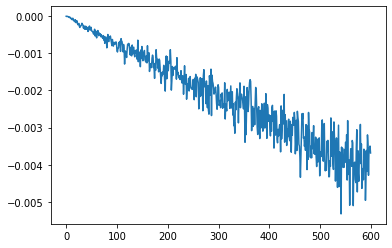

In [201]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)